In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from bmadx.plot import plot_projections
from bmadx.pmd_utils import openpmd_to_bmadx_beam, bmadx_beam_to_openpmd
from phase_space_reconstruction.analysis import screen_stats, get_beam_fraction_bmadx_beam, get_beam_fraction_bmadx_particle

In [2]:
data_dir = os.path.join('data', 'non_gaussian_beam')
t_scan_dir = os.path.join(data_dir, 't_scan')
n_par_dir = os.path.join(data_dir, 'n_par')

# Number of reconstruction study

In [3]:
# ground truth beam:
gt =  torch.load(os.path.join(n_par_dir, 'non_gaussian_beam.pt')).numpy_particles()
# reconstructions:
r_1e4 = torch.load(os.path.join(n_par_dir, '3D_scan_10_000.pt')).numpy_particles()
r_1e5 = torch.load(os.path.join(n_par_dir, '3D_scan_100_000.pt')).numpy_particles()
r_1e6 = torch.load(os.path.join(n_par_dir, '3D_scan_1_000_000.pt')).numpy_particles()
np.shape(np.stack(gt[:6]))

(6, 1000000)

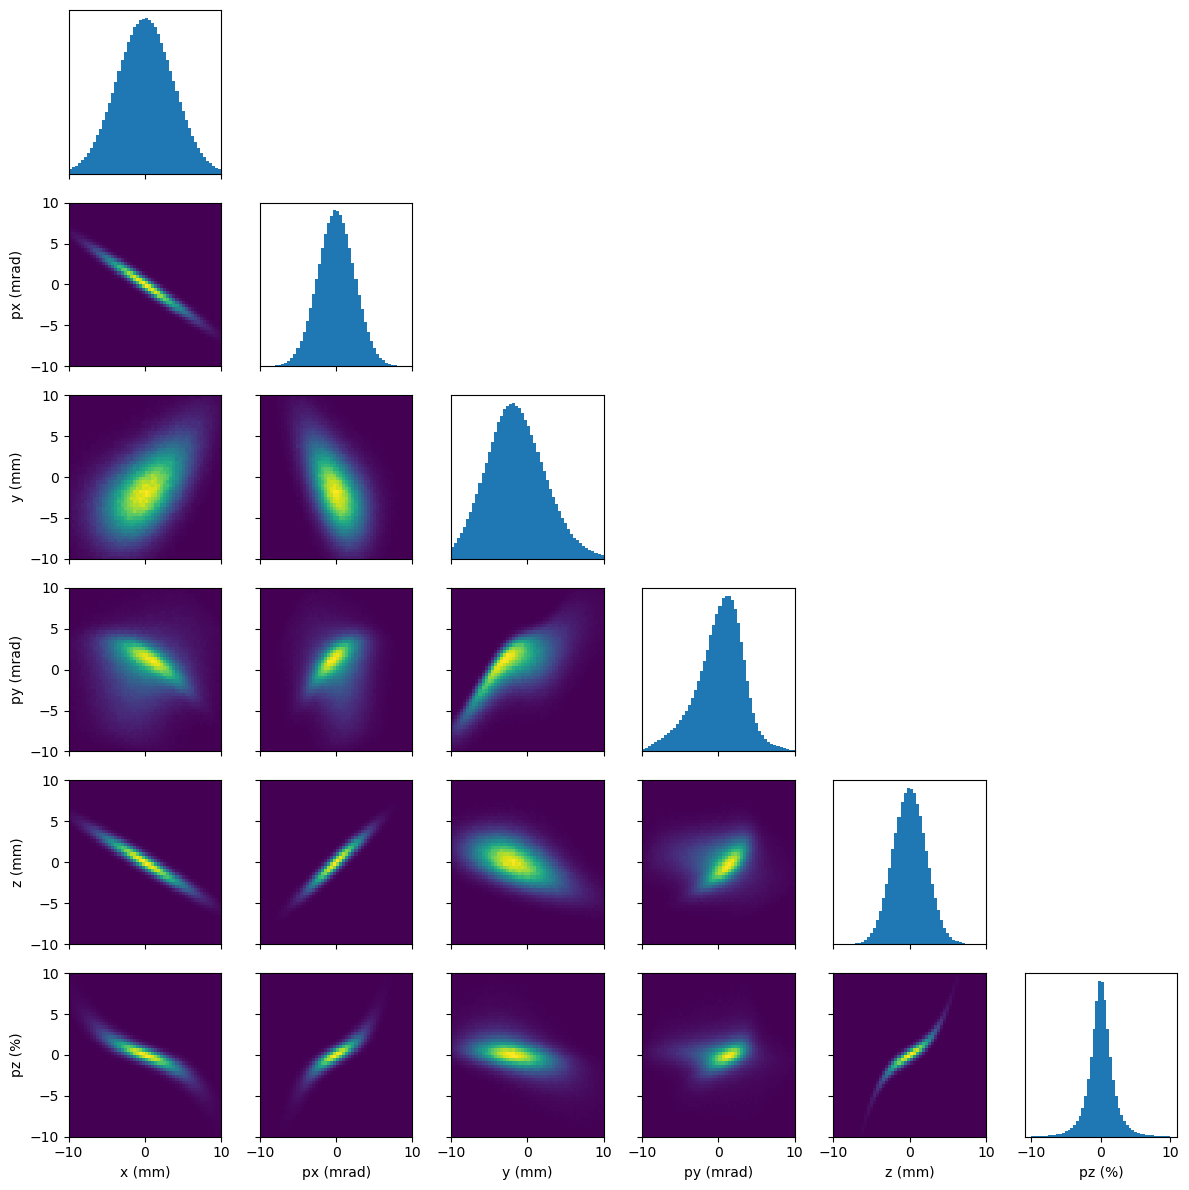

In [4]:
# plot gt:
lims = np.array([
    [-10e-3,10e-3],
    [-10e-3,10e-3],
    [-10e-3,10e-3],
    [-10e-3,10e-3],
    [-10e-3,10e-3],
    [-10e-2,10e-2]
])
plot_projections(gt, custom_lims=lims)
plt.show()

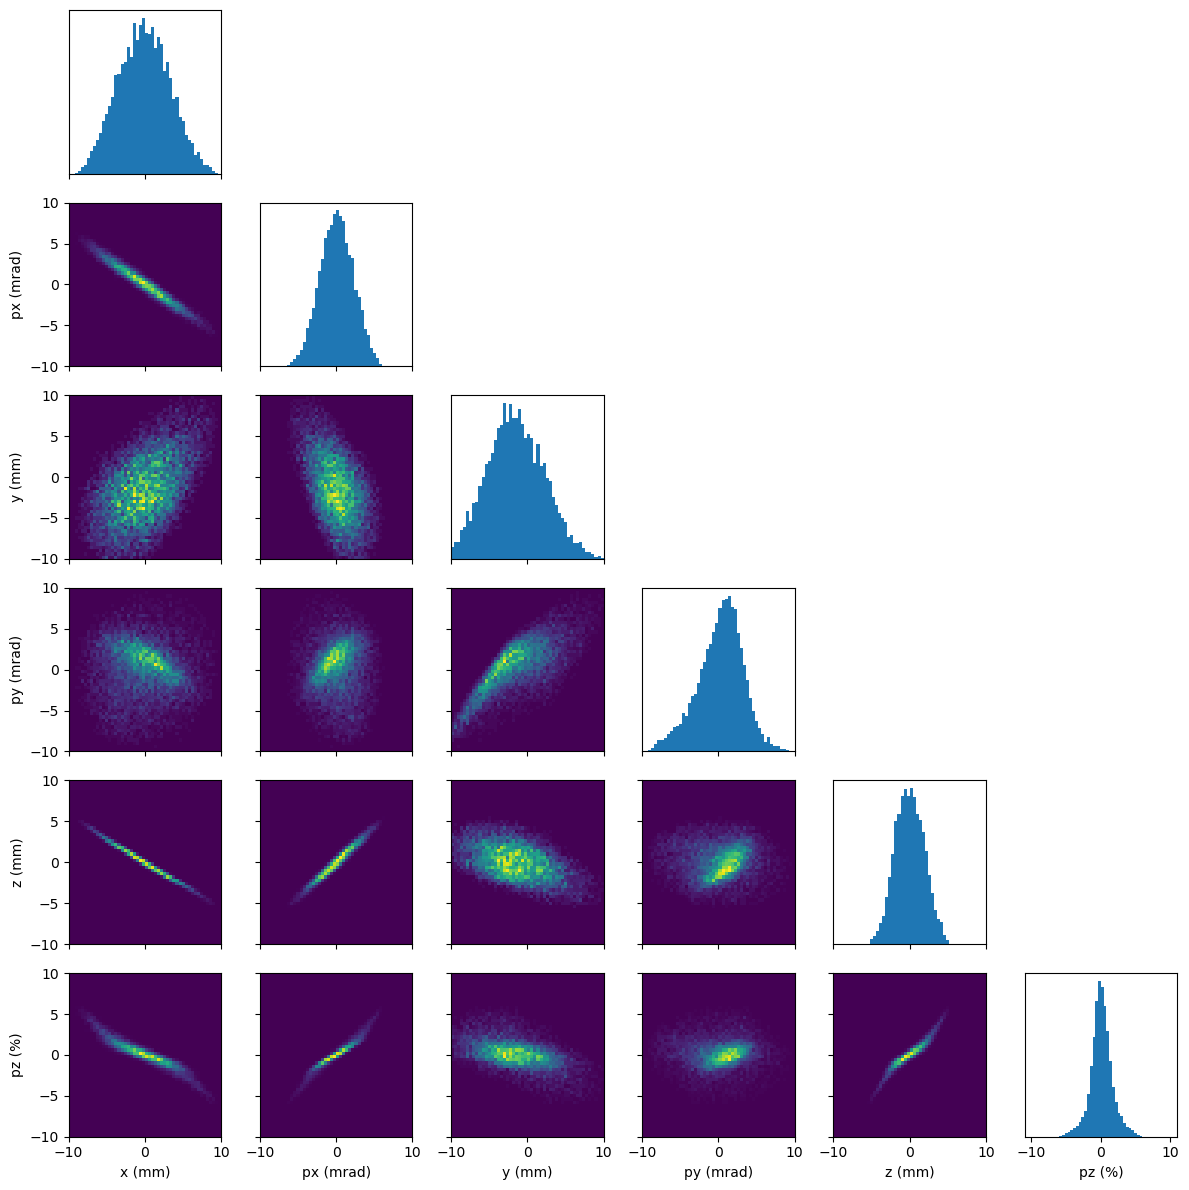

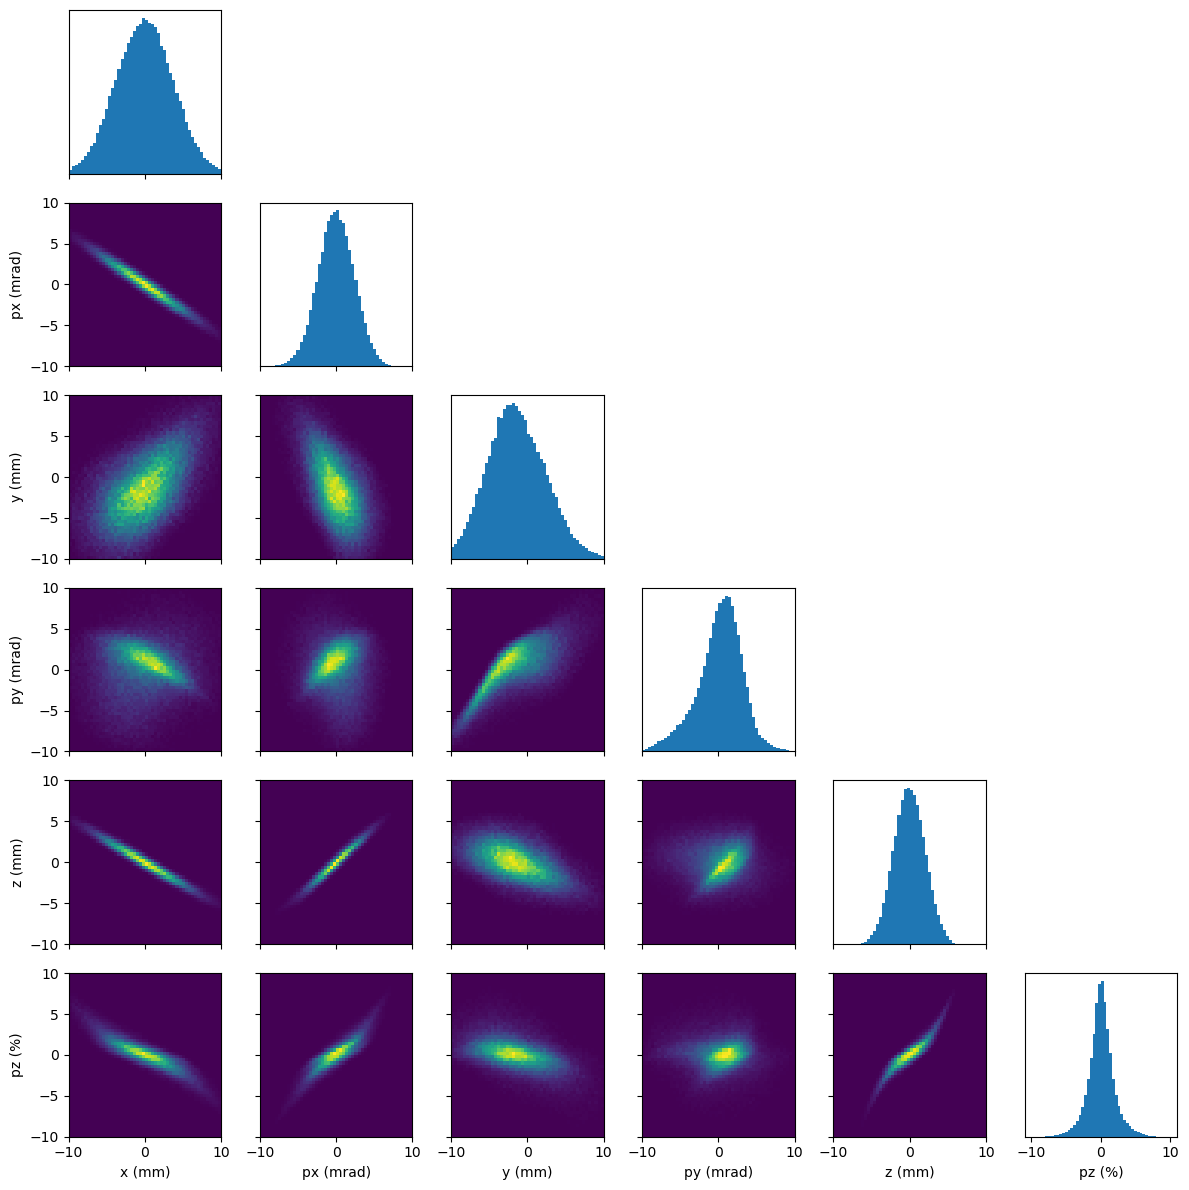

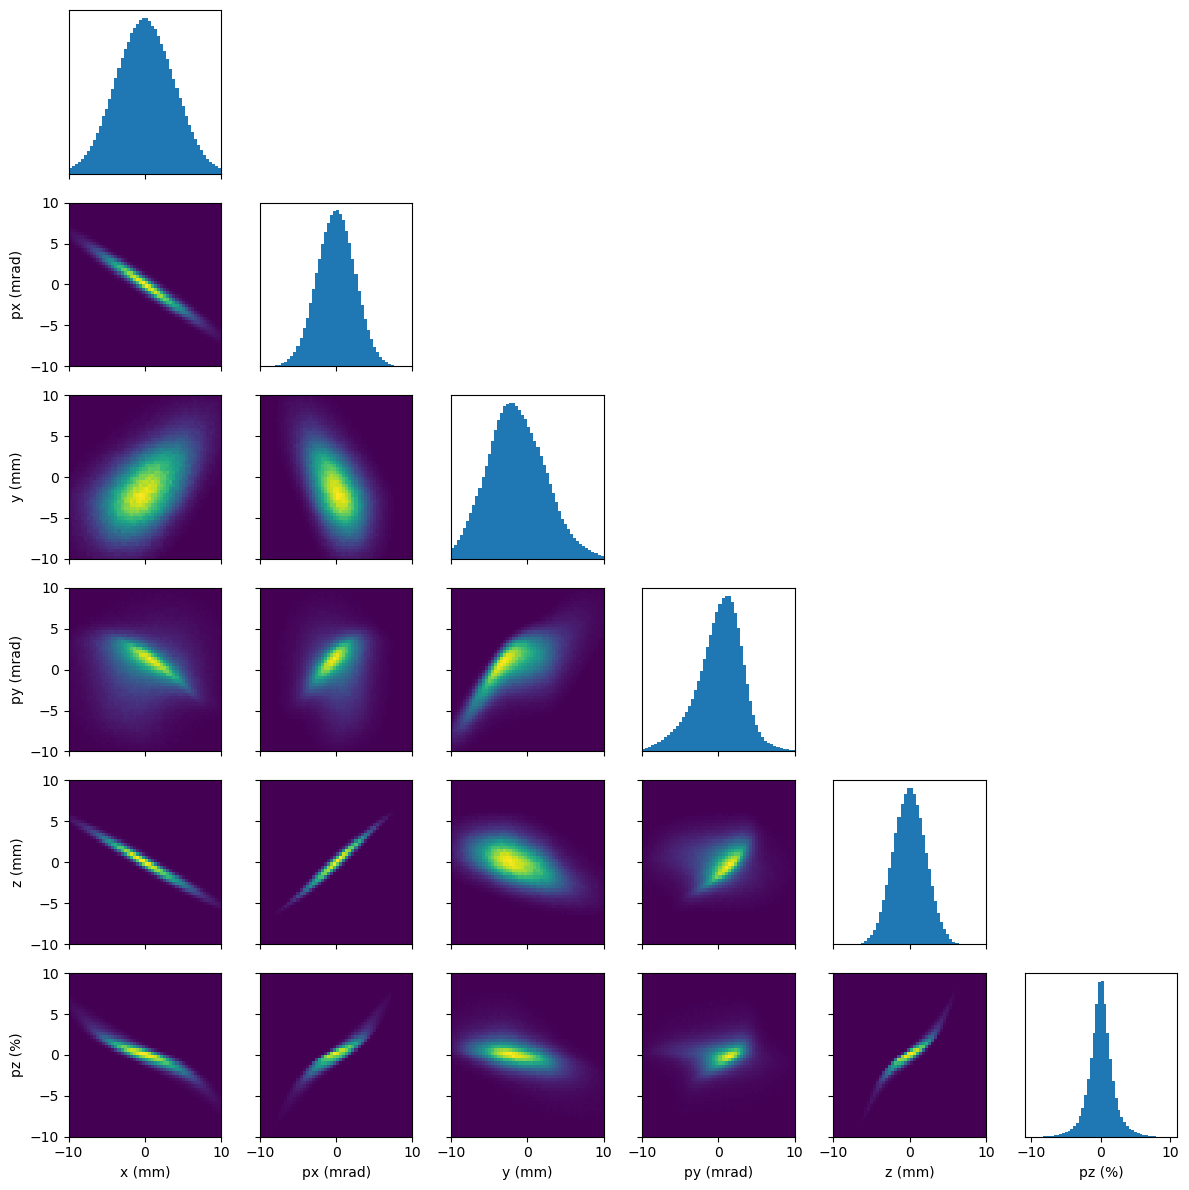

In [5]:
# plot recontructions:
plot_projections(r_1e4, custom_lims=lims)
plt.show()
plot_projections(r_1e5, custom_lims=lims)
plt.show()
plot_projections(r_1e6, custom_lims=lims)
plt.show()

In [6]:
gt_frac_50 = get_beam_fraction_bmadx_particle(gt, 0.5)
gt_frac_90 = get_beam_fraction_bmadx_particle(gt, 0.9)
gt_frac_95 = get_beam_fraction_bmadx_particle(gt, 0.95)

r_1e4_frac_50 = get_beam_fraction_bmadx_particle(r_1e4, 0.5)
r_1e4_frac_90 = get_beam_fraction_bmadx_particle(r_1e4, 0.9)
r_1e4_frac_95 = get_beam_fraction_bmadx_particle(r_1e4, 0.95)

r_1e5_frac_50 = get_beam_fraction_bmadx_particle(r_1e5, 0.5)
r_1e5_frac_90 = get_beam_fraction_bmadx_particle(r_1e5, 0.9)
r_1e5_frac_95 = get_beam_fraction_bmadx_particle(r_1e5, 0.95)

r_1e6_frac_50 = get_beam_fraction_bmadx_particle(r_1e6, 0.5)
r_1e6_frac_90 = get_beam_fraction_bmadx_particle(r_1e6, 0.9)
r_1e6_frac_95 = get_beam_fraction_bmadx_particle(r_1e6, 0.95)

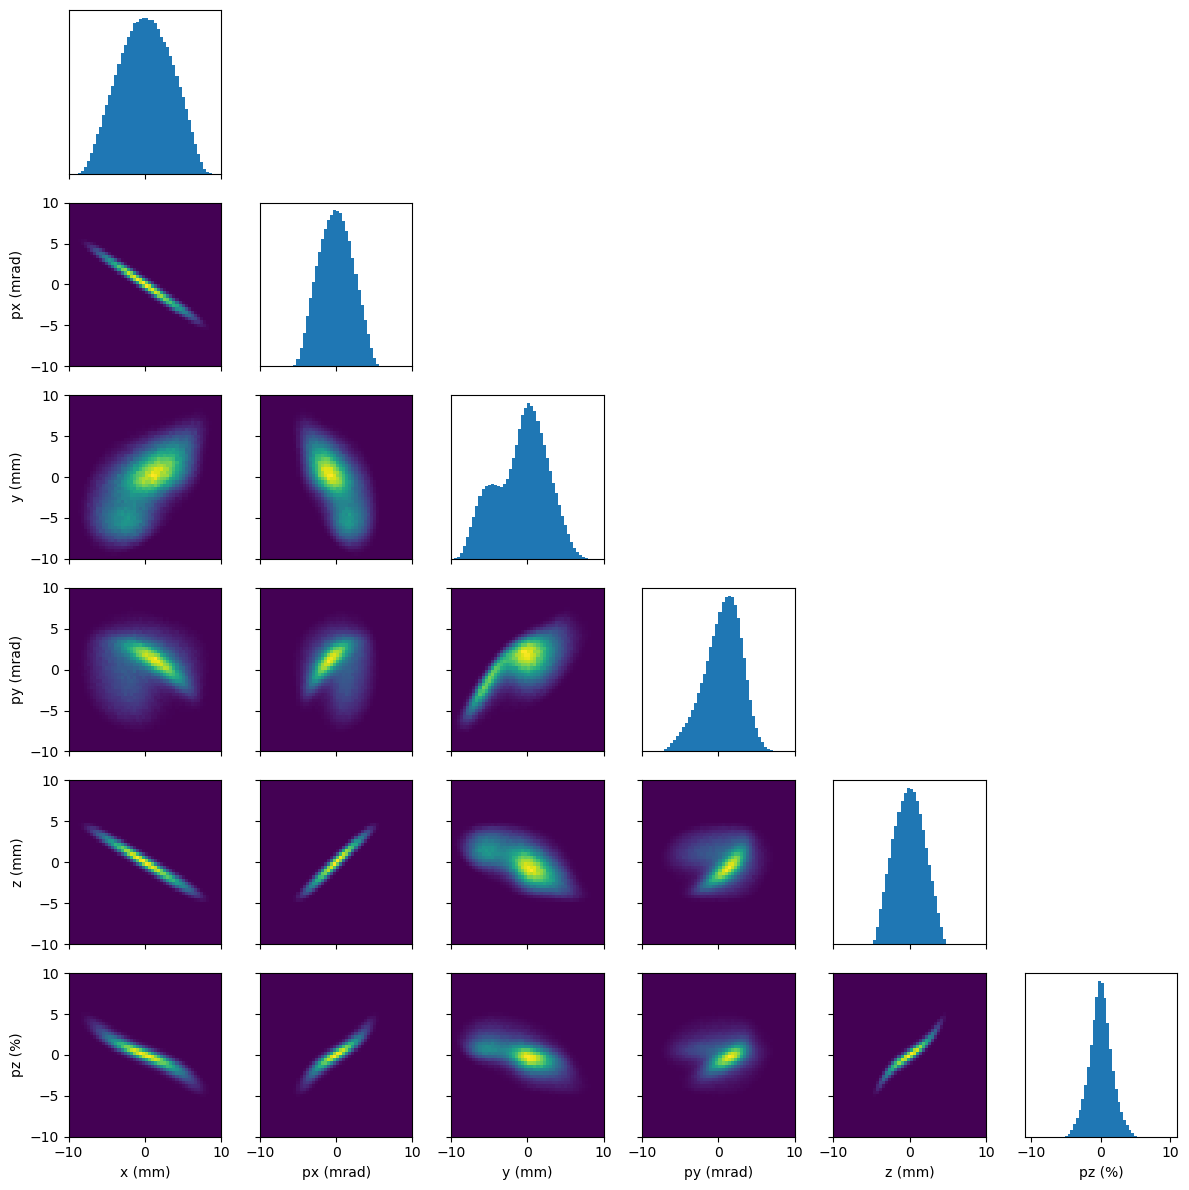

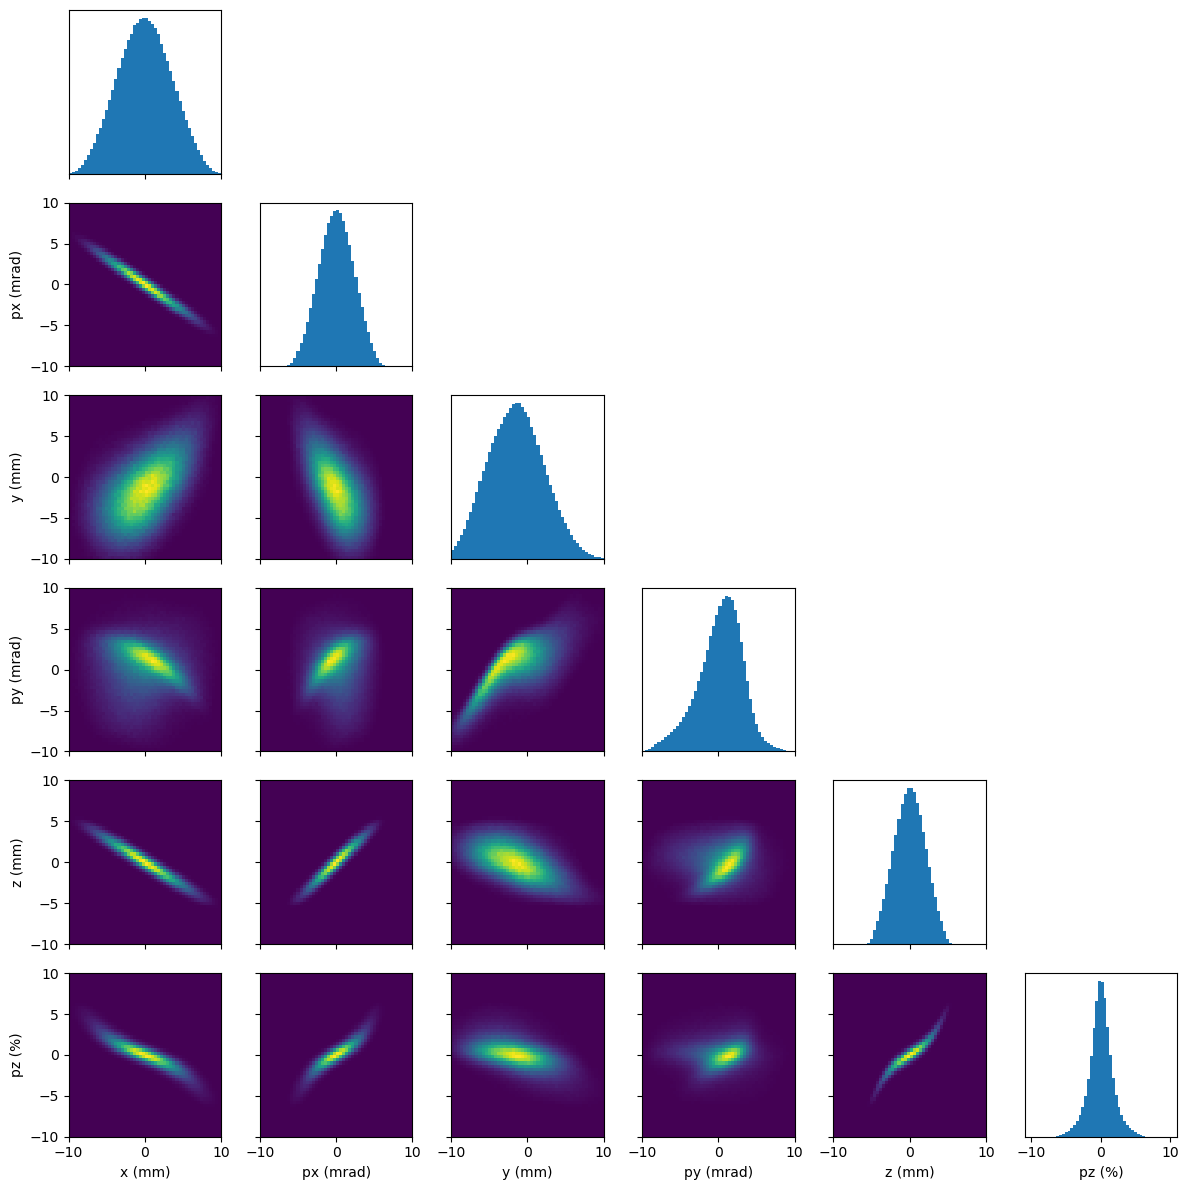

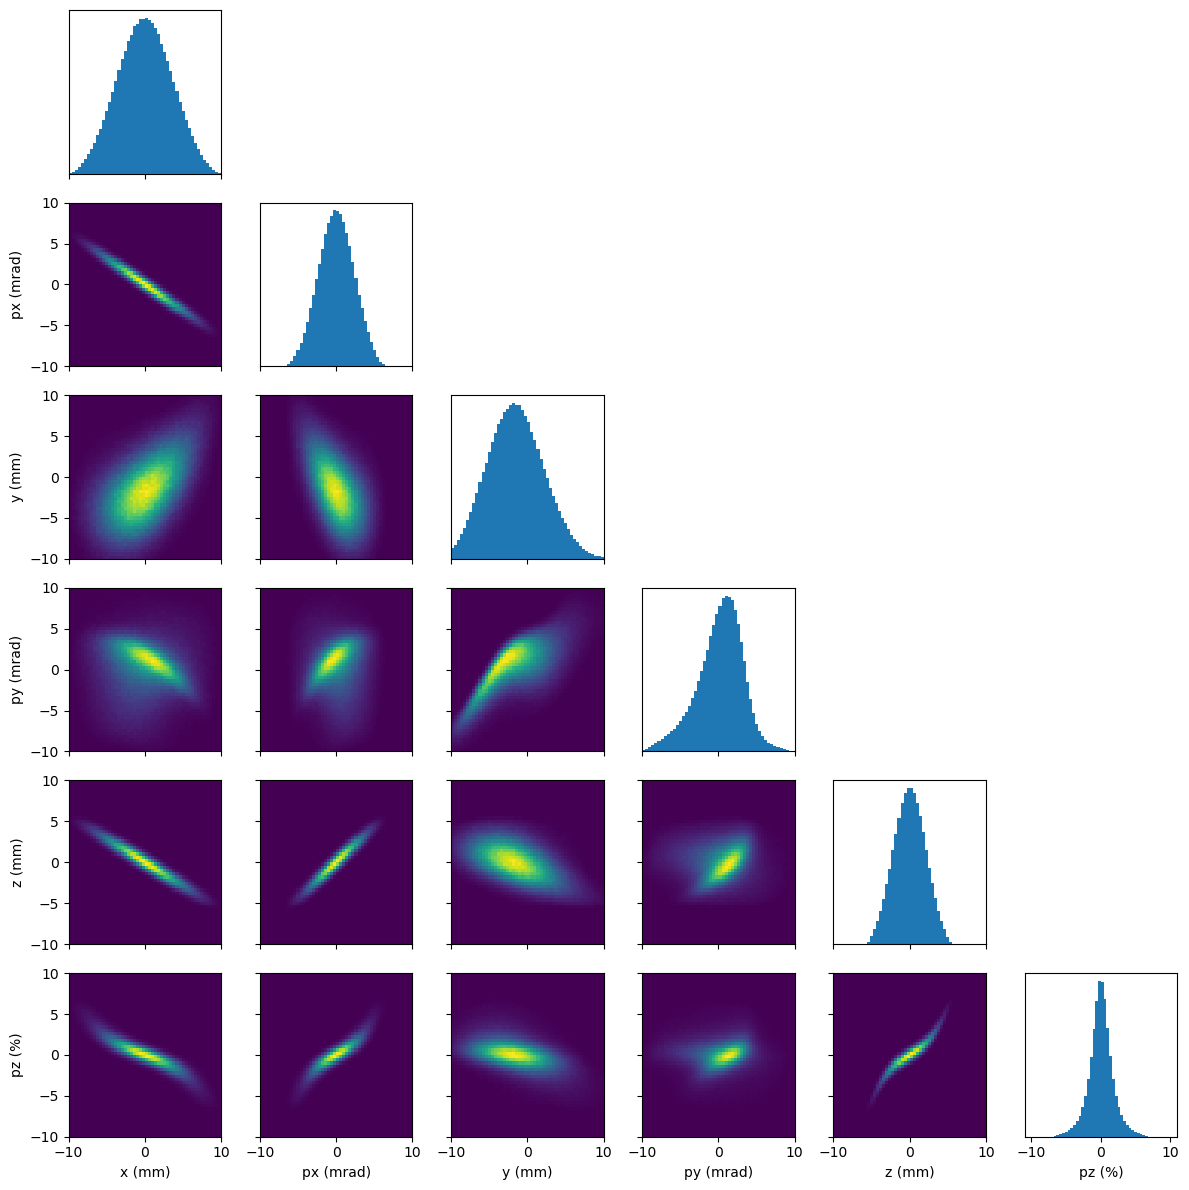

In [7]:
plot_projections(gt_frac_50, custom_lims=lims)
plt.show()
plot_projections(gt_frac_90, custom_lims=lims)
plt.show()
plot_projections(gt_frac_95, custom_lims=lims)
plt.show()

In [37]:
from scipy.ndimage import gaussian_filter
def plot_projections_with_contours(
        reconstruction,
        ground_truth,
        contour_levels = [0.25, 0.5],
        coords = ('x', 'px', 'y', 'py', 'z', 'pz'),
        bins = 200,
        scale = 1e3,
        background = 0,
        same_lims = False,
        custom_lims = None
        ):
    """
    Plot of coordinates projected into every possible 2D plane.
    
    Parameters
    ----------
    particles: bmadx.Particle
        beam to be plotted. If you have a bmadx_torch.Beam object, 
        you can use the numpy_particle() method to get the bmadx.Particle 

    coords: array-like
        coordinates that will be plotted. Should be a 
        subset of ('x', 'px', 'y', 'py', 'z', 'pz'). 
        Default: ('x', 'px', 'y', 'py', 'z', 'pz')

    bins: int
        number of bins in histograms.
        Default: 50
    
    scale: float
        scale factor for coordinates (except pz, which is always in %).
        1e3 for milimeters and miliradians, and 1 for meters and radians. 
        Default: 1e3

    background: bool
        if False, 0 frequency pixel of 2d histograms is converted to white.
        Default: False
    
    same_lims: bool
        if True, all coords will have the same limits given by the
        largest and lowest values in all coords.
        Default: False
    
    custom_lims: array 
        if provided, sets the lims of histograms for each coords. 
        if same_lims is Frue, custom lims should have shape 2
        providing min and max for every coord.
        if same_lims is False, custom lims should have shape
        (n_coords x 2).
        Default: None

    Returns
    -------
    fig and ax pyplot objects with the projections

    """
    SPACE_COORDS = ('x', 'y', 'z')
    MOMENTUM_COORDS = ('px', 'py', 'pz')

    n_coords = len(coords)
    print(n_coords)
    gt_fractions = []
    r_fractions = []
    for level in contour_levels:
        gt_fractions.append(
            get_beam_fraction_bmadx_particle(ground_truth, level)
        )
        r_fractions.append(
            get_beam_fraction_bmadx_particle(reconstruction, level)
        )

    fig_size = (n_coords*2,) * 2

    fig, ax = plt.subplots(n_coords, n_coords, figsize=fig_size)
    mycmap = plt.get_cmap('viridis')
    mycmap.set_under(color='white') # map 0 to this color

    all_coords = []
    
    for coord in coords:
        all_coords.append(getattr(reconstruction, coord))
    
    all_coords = np.array(all_coords)
    
    if same_lims:
        if custom_lims is None:
            coord_min = np.ones(n_coords)*all_coords.min()
            coord_max = np.ones(n_coords)*all_coords.max()
        elif len(custom_lims) == 2:
            coord_min = np.ones(n_coords)*custom_lims[0]
            coord_max = np.ones(n_coords)*custom_lims[1]
        else:
            raise ValueError("custom lims should have shape 2 when same_lims=True")
    else:
        if custom_lims is None:
            coord_min = all_coords.min(axis=1)
            coord_max = all_coords.max(axis=1)
        elif custom_lims.shape == (n_coords, 2):
            coord_min = custom_lims[:,0]
            coord_max = custom_lims[:,1]
        else:
            raise ValueError("custom lims should have shape (n_coords x 2) when same_lims=False")
    print(n_coords)
    for i in range(n_coords):

        x_coord = coords[i]

        if x_coord in SPACE_COORDS and scale==1e3:
            x_coord_unit = 'mm'
        elif x_coord in SPACE_COORDS and scale==1:
            x_coord_unit = 'm'
        elif x_coord in MOMENTUM_COORDS and scale==1e3:
            x_coord_unit = 'mrad'
        elif x_coord in MOMENTUM_COORDS and scale==1:
            x_coord_unit = 'rad'
        else:
            raise ValueError("""scales should be 1 or 1e3,
            coords should be a subset of ('x', 'px', 'y', 'py', 'z', 'pz')
            """)

        x_array = getattr(reconstruction, x_coord)*scale
        ax[n_coords-1,i].set_xlabel(f'{x_coord} ({x_coord_unit})')
        min_x = coord_min[i]*scale
        max_x = coord_max[i]*scale
        if i>0:
            ax[i,0].set_ylabel(f'{x_coord} ({x_coord_unit})')

        ax[i,i].hist(x_array,
                     bins=bins,
                     range=([min_x, max_x]))
        
        ax[i,i].yaxis.set_tick_params(left=False, labelleft=False)

        if i!= n_coords-1:
            ax[i,i].xaxis.set_tick_params(labelbottom=False)

        for j in range(i+1, n_coords):

            y_coord = coords[j]
            y_array = getattr(reconstruction, y_coord)*scale
            min_y = coord_min[j]*scale
            max_y = coord_max[j]*scale
            
            hist, x_edges, y_edges, _ = ax[j,i].hist2d(
                x_array,
                y_array,
                bins = bins,
                range=[[min_x, max_x],
                        [min_y, max_y]],
                cmap = mycmap,
                vmin = background
                )
            
            x_centers = (x_edges[:-1] + x_edges[1:]) / 2
            y_centers = (y_edges[:-1] + y_edges[1:]) / 2

            for k in range(len(contour_levels)):
                h_gt_fractions, _, _ = np.histogram2d(
                    getattr(gt_fractions[k], x_coord)*scale,
                    getattr(gt_fractions[k], y_coord)*scale,
                    bins = bins,
                    range = [[min_x, max_x],
                        [min_y, max_y]]
                )
                h_r_fractions, _, _ = np.histogram2d(
                    getattr(r_fractions[k], x_coord)*scale,
                    getattr(r_fractions[k], y_coord)*scale,
                    bins = bins,
                    range = [[min_x, max_x],
                        [min_y, max_y]]
                )
                ax[j,i].contour(
                    x_centers, 
                    y_centers, 
                    gaussian_filter(h_gt_fractions, 3).T,
                    levels=[1],
                    linestyles="-",
                    colors=["black","grey","white"][::-1],
                    linewidths=1)
                ax[j,i].contour(
                    x_centers, 
                    y_centers, 
                    gaussian_filter(h_r_fractions, 3).T,
                    levels=[1],
                    linestyles="--",
                    colors=["black","grey","white"][::-1],
                    linewidths=1)
            

            ax[j,i].get_shared_x_axes().join(ax[j,i], ax[i,i])

            ax[i,j].set_visible(False)

            if i != 0:
                ax[j, i].yaxis.set_tick_params(labelleft=False)
            
            if j != n_coords-1:
                ax[j,i].xaxis.set_tick_params(labelbottom=False)

    fig.tight_layout()

    return fig, ax

6
6


/var/folders/4z/9l_r5w4j0716ckrsr_m2v8zh0000gn/T/ipykernel_10371/458672165.py:191: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[j,i].get_shared_x_axes().join(ax[j,i], ax[i,i])


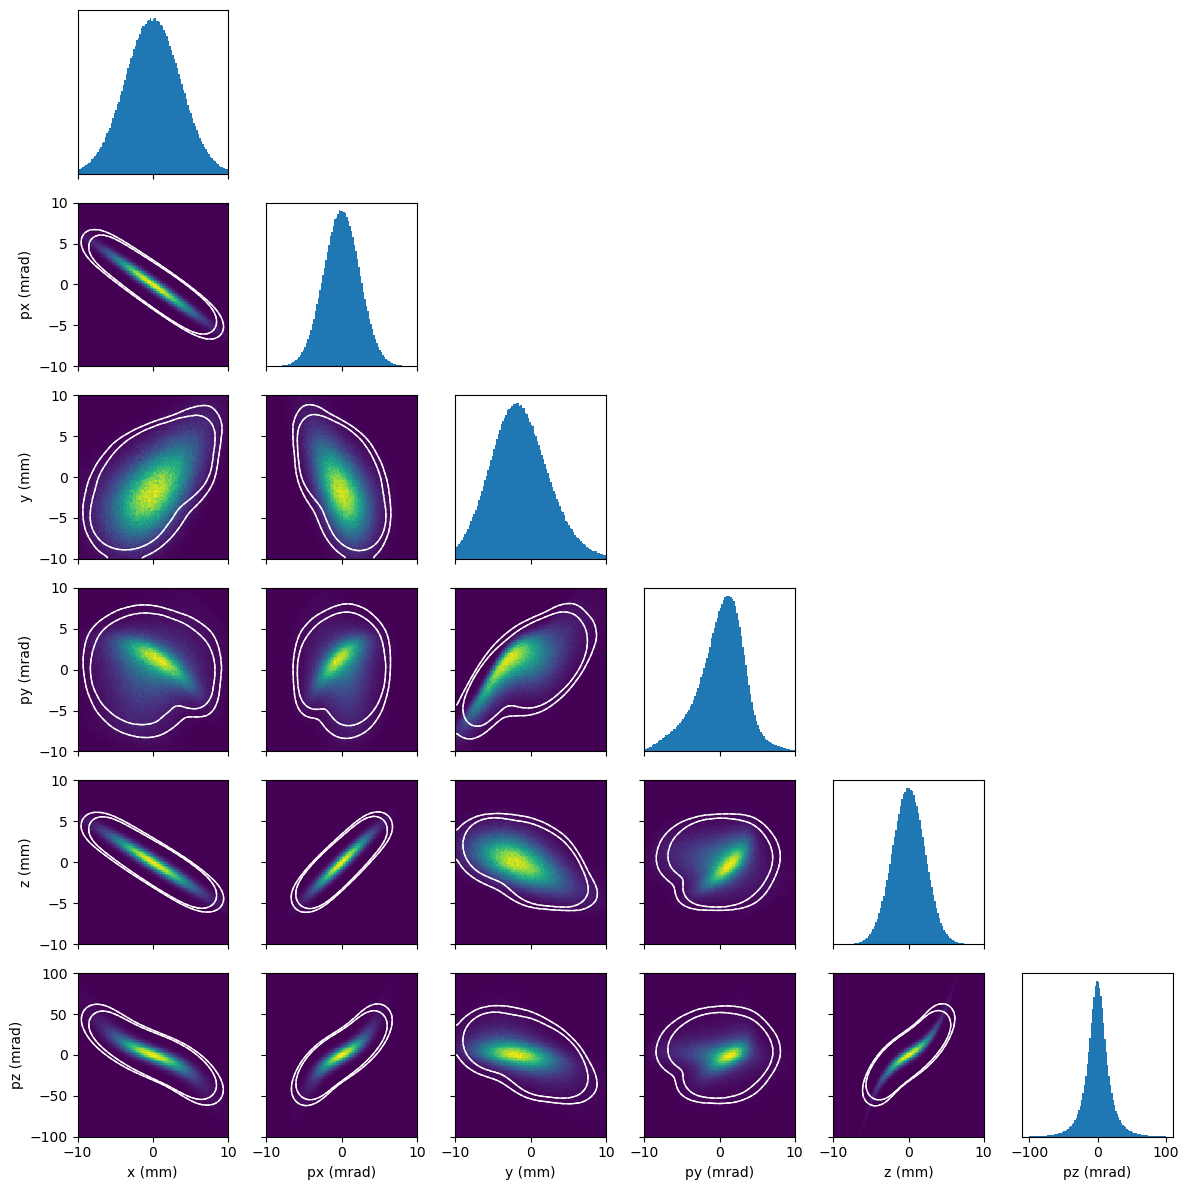

In [38]:
fig, ax = plot_projections_with_contours(
    gt,
    gt,
    bins=100,
    custom_lims=lims
)
plt.show()

In [10]:
rng = [[-10e-3,10e-3],[-10e-2,10e-2]]
bins = [200,200]
hist_gt, b_x, b_px =  np.histogram2d(gt.z, gt.pz, bins=bins, range=rng)
hist_gt_frac_50, _, _ =  np.histogram2d(gt_frac_50.z, gt_frac_50.pz, bins=bins, range=rng)
hist_gt_frac_95, _, _ =  np.histogram2d(gt_frac_95.z, gt_frac_95.pz, bins=bins, range=rng)
hist_r_1e4, _, _ = np.histogram2d(r_1e4.z, r_1e4.pz, bins=bins, range=rng)

In [11]:
gt_mx = hist_gt.max()
gt_frac_50_mx = hist_gt_frac_50.max()
r_1e4_mx = hist_r_1e4.max()

x1c = (b_x[:-1] + b_x[1:]) / 2
x2c = (b_px[:-1] + b_px[1:]) / 2
X, Y = np.meshgrid(b_x,b_px)
Xc, Yc = np.meshgrid(x1c,x2c)

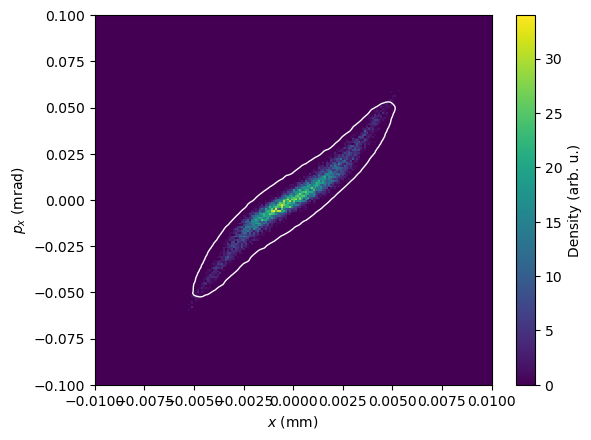

In [12]:
fig, ax = plt.subplots()
c1 = ax.pcolor(X, Y, hist_r_1e4.T)
    #ax.contour(Xc, Yc, h_reconstruction.T,levels=3)
c2 = ax.contour(x1c, x2c, gaussian_filter(hist_gt_frac_50, 1).T, levels=[1],linestyles="-",
                        colors=["black","grey","white"][::-1],linewidths=1)
#ax.clabel(
#                c2, inline=True, fontsize=8,
#                fmt=dict(zip(clevels,[f"{ele}" for ele in quantiles[::-1]])),
#                manual=[(1.5*kk/3, 0.15*kk/3) for kk in range(len(quantiles))]
#            )
ax.set_xlabel(r"$x$ (mm)")
ax.set_ylabel(r"$p_x$ (mrad)")
cbar = fig.colorbar(c1,label="Density (arb. u.)")

In [13]:
from scipy.ndimage import median_filter, gaussian_filter
from matplotlib.lines import Line2D

In [14]:
#hist, b_x, b_px = np.histogram2d(x, px, density=True, bins=[100,100])
#np.shape(hist)
hist = hist_gt

In [15]:
vmax = hist.max()
vmax

1647.0

In [16]:
test_levels = np.linspace(0, vmax, 100)
total = hist.sum()
total

997111.0

In [17]:
sums = []
for ele in test_levels:
    sums += [np.where(hist >= ele, hist, 0.0).sum() / total]
sums = np.array(sums)

In [18]:
quantiles = [0.50]
levels = []
for ele in quantiles[::-1]:
    diff = sums - ele
    levels += [test_levels[np.where(np.diff(np.sign(diff)))]]
clevels = np.array(levels).flatten()
x1c = (b_x[:-1] + b_x[1:]) / 2
x2c = (b_px[:-1] + b_px[1:]) / 2

In [19]:
X, Y = np.meshgrid(b_x,b_px)
Xc, Yc = np.meshgrid(x1c,x2c)
np.shape(Y)

(201, 201)

NameError: name 'hist_r_10_000' is not defined

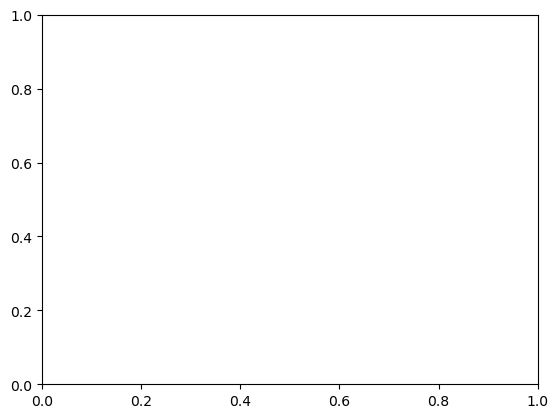

In [20]:
fig, ax = plt.subplots()
c1 = ax.imshow
c1 = ax.pcolor(X, Y, hist_r_10_000.T)
    #ax.contour(Xc, Yc, h_reconstruction.T,levels=3)
c2 = ax.contour(Xc, Yc, hist.T, levels=clevels,linestyles="dashed",
                        colors=["black","grey","white"][::-1],linewidths=1)
#ax.clabel(
#                c2, inline=True, fontsize=8,
#                fmt=dict(zip(clevels,[f"{ele}" for ele in quantiles[::-1]])),
#                manual=[(1.5*kk/3, 0.15*kk/3) for kk in range(len(quantiles))]
#            )
ax.set_xlabel(r"$x$ (mm)")
ax.set_ylabel(r"$p_x$ (mrad)")
cbar = fig.colorbar(c1,label="Density (arb. u.)")

# 3D scan vs 'T' scan

In [ ]:
gt_2 = torch.load(os.path.join(t_scan_dir, 'non_gaussian_beam.pt'))
r_3d_scan = torch.load(os.path.join(t_scan_dir, '3D_scan_100_000.pt'))
r_t_scan = torch.load(os.path.join(t_scan_dir, 't_scan_100_000.pt'))

In [ ]:
# plot ground truth beam:
plot_projections(gt_2.numpy_particles(), custom_lims=lims)
plt.show()

In [ ]:
# plot 3d scan reconstructed beam
plot_projections(r_3d_scan.numpy_particles(), custom_lims=lims)
plt.show()

In [ ]:
# plot t scan reconstructed beam
plot_projections(r_t_scan.numpy_particles(), custom_lims=lims)
plt.show()

In [ ]:
beam_gt_frac_50 = get_beam_fraction_bmadx_beam(beam_ground_truth, 0.5)
beam_gt_frac_90 = get_beam_fraction_bmadx_beam(beam_ground_truth, 0.9)
beam_gt_frac_95 = get_beam_fraction_bmadx_beam(beam_ground_truth, 0.95)

beam_3d_frac_50 = get_beam_fraction_bmadx_beam(beam_3d_scan, 0.5)
beam_3d_frac_90 = get_beam_fraction_bmadx_beam(beam_3d_scan, 0.9)
beam_3d_frac_95 = get_beam_fraction_bmadx_beam(beam_3d_scan, 0.95)

beam_t_frac_50 = get_beam_fraction_bmadx_beam(beam_t_scan, 0.5)
beam_t_frac_90 = get_beam_fraction_bmadx_beam(beam_t_scan, 0.9)
beam_t_frac_95 = get_beam_fraction_bmadx_beam(beam_t_scan, 0.95)

In [ ]:
plot_projections(beam_t_frac_50.numpy_particles())

In [ ]:
plot_projections(beam_3d_frac_50.numpy_particles())

In [ ]:
plot_projections(beam_gt_frac_50.numpy_particles())